## CO2 Sequestration in NYC Street Trees Between 1995 and 2015

#### How much CO2 did NYC's dominant tree species store in a 20 year period?

### Methods 
* Identify which species included most of the large (above average dbh) trees in the city in 1995 and 2015.
* Determine CO2 stored by these species in 1995 and 2015 using process described by the US Forest Service. 
* Visualize results with bar and pie charts. 

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [150]:
import matplotlib.colors as mcolors

In [2]:
pd.options.mode.chained_assignment = None

In [59]:
os.chdir('C:/Users/roseh/Desktop/785/tree_census/Data')

In [60]:
# read in all dataframes

tree_1995 = pd.read_csv('1995_Street_Tree_Census.csv')
tree_2015 = pd.read_csv('2015_Street_Tree_Census.csv')

### Tidy and Explore Data

In [61]:
os.chdir('C:/Users/roseh/Desktop/785/tree_census')

In [62]:
# equations require dbh in centimeters
# add new column to dataframes converting dbh measurement from inches to centimeters

tree_1995['dbh_cm'] = tree_1995['Diameter']*2.54
tree_2015['dbh_cm'] = tree_2015['tree_dbh']*2.54

# drop rows with na values
tree_1995 = tree_1995.dropna(axis=0, how='any')
tree_2015 = tree_2015.dropna(axis=0, how='any')

# rename dbh column to match
tree_1995.rename(columns={'Diameter':'tree_dbh'}, inplace=True)

In [75]:
# create boxplot to visualize changes in dbh

def plot_dbh(df):
    """"Create boxplot comparing dbh of trees in 1995 and 2015""" 
    
    fig,ax = plt.subplots(figsize=(10,5))                                              

    sns.boxplot(data=df[['1995','2015']],
                ax=ax,
                orient='h', 
                flierprops={"marker": "o"}, 
                fliersize=1)
    ax.set_title('Tree Diameter (inches)')
 
    plt.show()

C:\Users\roseh\miniconda3\envs\rs-env\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


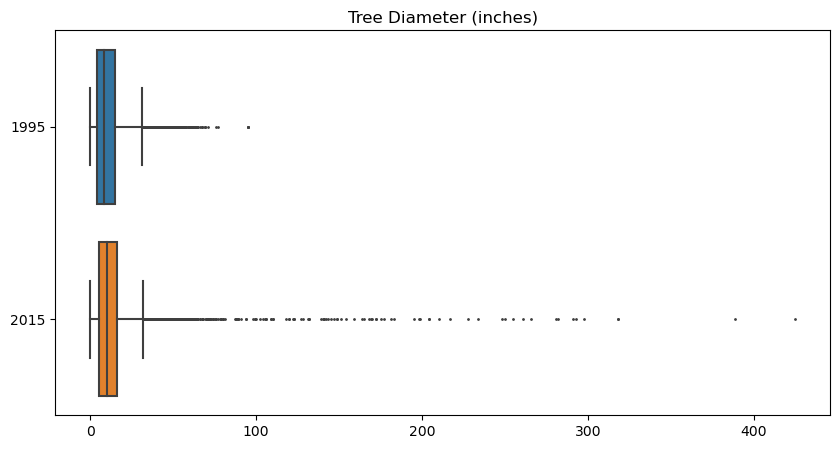

In [76]:
dbh_df = pd.DataFrame({'1995':tree_1995['tree_dbh'],'2015':tree_2015['tree_dbh']}) 
plot_dbh(dbh_df)

* The large outlier values seem strange. The [NYC Tree Census summary](https://www.nycgovparks.org/trees/treescount) states that the largest trees counted were between 57-87 inches in diameter.

### Remove Outliers

In [187]:
def remove_outliers(df):
    """Return dataframe containing only trees with dbh > upper bound of IQR"""
    
    q75,q25 = np.percentile(df['tree_dbh'],[75,25])
    intr_qr = q75-q25
 
    upper = q75+(1.5*intr_qr)
    
    return df[df['tree_dbh'] < upper]

In [69]:
tree_1995_n = remove_outliers(tree_1995)

In [71]:
tree_2015_n = remove_outliers(tree_2015)

C:\Users\roseh\miniconda3\envs\rs-env\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


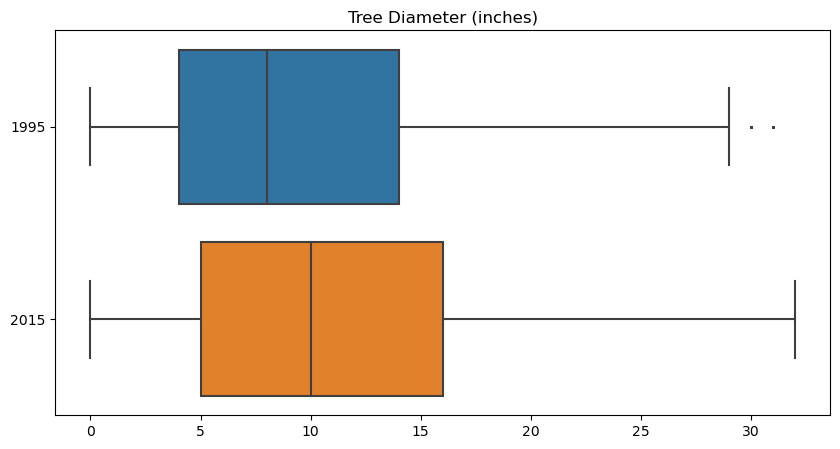

In [77]:
dbh_df_n = pd.DataFrame({'1995':tree_1995_n['tree_dbh'],'2015':tree_2015_n['tree_dbh']})
plot_dbh(dbh_df_n)

In [95]:
# print mean and median dbh for each year

print('\t1995\nTree count:', len(tree_1995_n),'\nMean dbh:',np.around(tree_1995_n['tree_dbh'].mean(),2),'\nMedian dbh:',tree_1995_n['tree_dbh'].median())
print('\n\t2015\nTree count:', len(tree_2015_n),'\nMean dbh:',np.around(tree_2015_n['tree_dbh'].mean(),2),'\nMedian dbh:',tree_2015_n['tree_dbh'].median())

print(f'\nNYC gained {len(tree_2015_n) - len(tree_1995_n)} new trees between 1995 and 2015')

	1995
Tree count: 249674 
Mean dbh: 9.93 
Median dbh: 8.0

	2015
Tree count: 627752 
Mean dbh: 11.09 
Median dbh: 10.0

NYC gained 378078 new trees between 1995 and 2015


### Which species have the most trees with above average dbh?

In [134]:
# select only trees with (dbh > mean) and create new dataframes

mean_dbh_95 = tree_1995_n['tree_dbh'].mean()
mean_dbh_15 = tree_2015_n['tree_dbh'].mean()

largest_1995 = tree_1995_n[tree_1995_n['tree_dbh'] > mean_dbh_95]
largest_2015 = tree_2015_n[tree_2015_n['tree_dbh'] > mean_dbh_15]

In [138]:
# standardize names of top 10 species for convenience

names_95 = {'LONDON PLANETREE': 'London Planetree', 'MAPLE, NORWAY': 'Norway Maple', 'OAK, PIN': 'Pin Oak', 'MAPLE, SUGAR': 'Sugar Maple',
         'MAPLE, RED': 'Red Maple', 'HONEYLOCUST': 'Honeylocust', 'LINDEN, LITTLE LEAF': 'Linden', 'MAPLE, SYCAMORE': 'Sycamore Maple',
            'GINKGO': 'Ginkgo', 'MAPLE, SILVER': 'Silver Maple'}

names_15 = {'London planetree': 'London Planetree', 'Norway maple': 'Norway Maple', 'pin oak': 'Pin Oak', 'MAPLE, SUGAR': 'Sugar Maple',
         'red maple': 'Red Maple', 'honeylocust': 'Honeylocust', 'littleleaf linden': 'Linden', 'MAPLE, SYCAMORE': 'Sycamore Maple',
            'GINKGO': 'Ginkgo', 'silver maple': 'Silver Maple', 'Callery pear': 'Callery Pear', 'green ash': 'Green Ash',
           'Japanese zelkova': 'Japanese Zelkova'}

largest_1995['Spc_Common'] = largest_1995['Spc_Common'].replace(names_95)
largest_2015['spc_common'] = largest_2015['spc_common'].replace(names_15)

In [182]:
top_species_1995 = largest_1995['Spc_Common'].value_counts().head(10)     # define top 10 species in 1995 
top_species_1995_df = pd.DataFrame(top_species_1995).reset_index()

In [178]:
top_species_2015 = largest_2015['spc_common'].value_counts().head(10)     # define top 10 species in 2015
top_species_2015_df = pd.DataFrame(top_species_2015).reset_index()

In [185]:
# create color dictionary keyed to species for plotting

colors = [color for color in mcolors.TABLEAU_COLORS]  # Grab 13 random colors
for c in ['hotpink','darkviolet','mediumblue']:
    colors.append(c)

species_95 = set(top_species_1995.index.unique())
species_15 = set(top_species_2015.index.unique())
species = list(species_95 | species_15)

color_dict = dict(zip(species,colors))

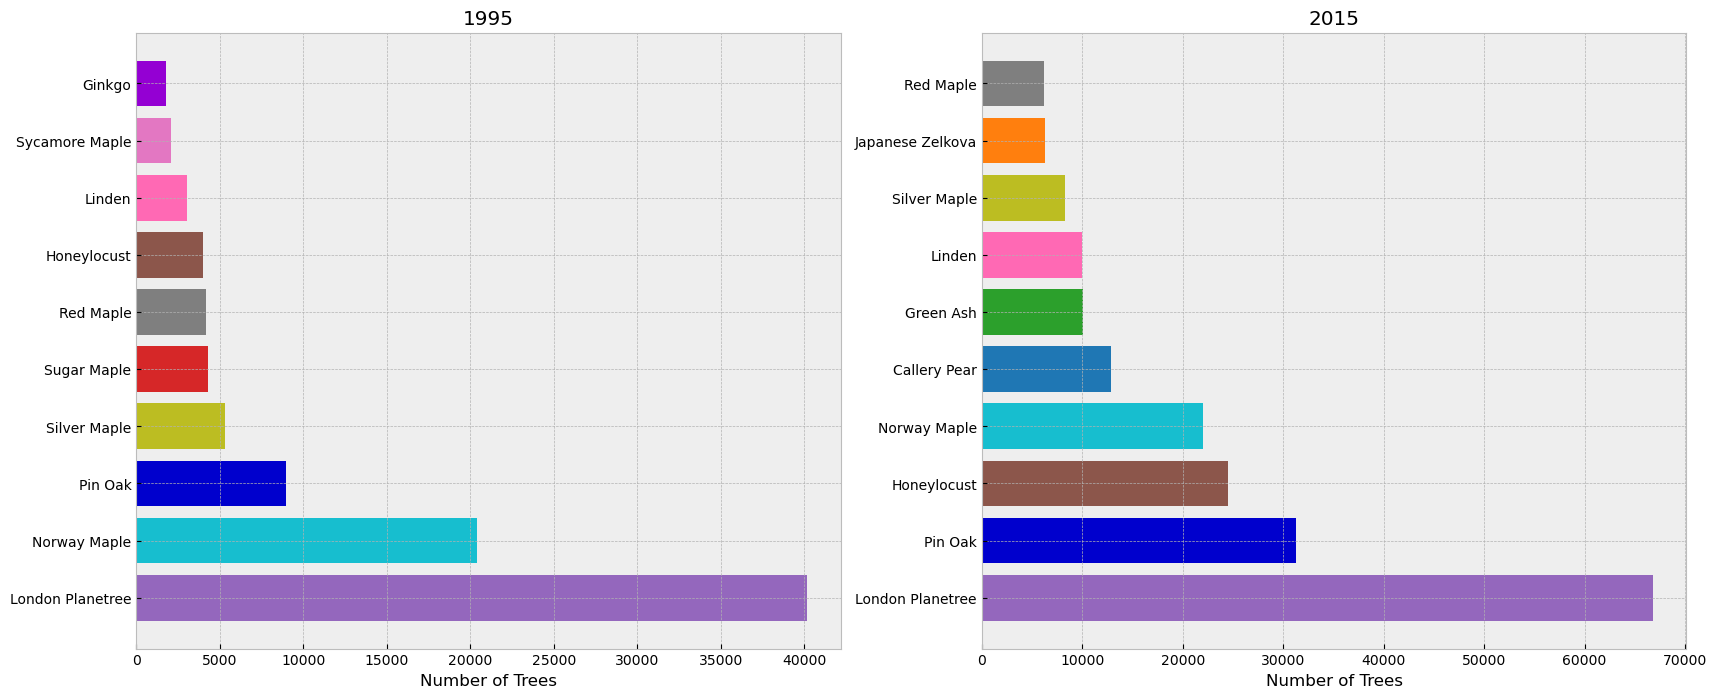

In [184]:
# plot bar charts showing tree counts for top species each year

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
plt.style.use('bmh')
ax1.barh(top_species_1995.index.str.title(),top_species_1995, color=top_species_1995_df['index'].replace(color_dict))
ax1.set_title('1995')
ax1.set_xlabel('Number of Trees')

ax2.barh(top_species_2015.index.str.title(),top_species_2015, color=top_species_2015_df['index'].replace(color_dict))
ax2.set_title('2015')
ax2.set_xlabel('Number of Trees')

plt.savefig(os.path.join('images', 'species_counts.png'))
plt.show()

- In both years, most of the larger trees in the city were London Planetrees. 
- Sycamore Maple, Ginkgo, and Sugar Maple appear only in 1995.
- They are replaced by Japanese Zelkova, Green Ash and Callery Pear in 2015.

### How Much CO2 Was stored by these Species Between 1995 and 2015?

According to the Urban Tree Database and Allometric Equations, the process for calculating the amount of CO2 sequestered in a tree is as follows:
- Find the aboveground dry weight biomass of the tree by using the species appropriate allometric equation.
- Multiply the this biomass by 1.28 to incorporate belowground biomass.
- Multiply by the constant 0.5 to convert to total carbon stored in kg.
- Multiply by the constant 3.67 (the molecular weight of CO2) to convert to the total CO2 stored in kg.

In [102]:
# define a function to iterate over a list of dataframes and perform the above calculations

def get_carbon_storage(df_list,function_list):
    """Apply allometric equation to corresponding tree species and add dry weight biomass column
    and CO2 storage column to dataframe"""
    
    zipped = zip(df_list,function_list)
    for df,function in list(zipped):
        df['dw_biomass'] = df['dbh_cm'].apply(function)
        df['CO2'] = df['dw_biomass']*1.28*.5*3.67
    

In [103]:
# select only trees with dbh greater than 0 (to avoid zero division error in some allometric equations)

greater_than_0_1995 = tree_1995_n[tree_1995_n['tree_dbh']>0]
greater_than_0_2015 = tree_2015_n[tree_2015_n['tree_dbh']>0]

In [104]:
# group the dataframes by species

species_groups_1995 = greater_than_0_1995.groupby('Spc_Common')
species_groups_2015 = greater_than_0_2015.groupby('spc_common')

In [105]:
# define empty lists for dataframes and functions that will be input into get_carbon_storage function

function_list = []
species_list_1995 = []    # list to hold 1995 species dataframes
species_list_2015 = []    # list to hold 2015 species dataframes

In [106]:
# define separate dataframes for each species and define allometric functions for each species.
# append each dataframe and function to the corresponding list.

londonplane_1995 = species_groups_1995.get_group('LONDON PLANETREE')
londonplane_2015 = species_groups_2015.get_group('London planetree')

londonplane_function = lambda x: (0.000059*x**2.673578) * 500    # equation for volume, multiplied by density factor

species_list_1995.append(londonplane_1995)          
species_list_2015.append(londonplane_2015)
function_list.append(londonplane_function)

In [107]:
norwaymaple_1995 = species_groups_1995.get_group('MAPLE, NORWAY')
norwaymaple_2015 = species_groups_2015.get_group('Norway maple')

norwaymaple_function = lambda x: (0.0019421*x**1.785) * 520      # equation for volume, multiplied by density factor

species_list_1995.append(norwaymaple_1995)
species_list_2015.append(norwaymaple_2015)
function_list.append(norwaymaple_function)

In [109]:
pinoak_1995 = species_groups_1995.get_group('OAK, PIN')
pinoak_2015 = species_groups_2015.get_group('pin oak')

# no specific function available; using general equation for maple/oak/hickory/beech
pinoak_function = lambda x: np.exp(-2.0127+2.4342*np.log(x))- np.exp((-4.0813+5.8816/x))

species_list_1995.append(pinoak_1995)
species_list_2015.append(pinoak_2015)
function_list.append(pinoak_function)

In [110]:
silvermaple_1995 = species_groups_1995.get_group('MAPLE, SILVER')
silvermaple_2015 = species_groups_2015.get_group('silver maple')

silvermaple_function = lambda x: (0.000363*x**2.292) * 440       # equation for volume, multiplied by density factor

species_list_1995.append(silvermaple_1995)
species_list_2015.append(silvermaple_2015)
function_list.append(silvermaple_function)

In [111]:
redmaple_1995 = species_groups_1995.get_group('MAPLE, RED')
redmaple_2015 = species_groups_2015.get_group('red maple')

redmaple_function = lambda x: 0.1970*x**2.1933             # equation for dry weight biomass

species_list_1995.append(redmaple_1995)
species_list_2015.append(redmaple_2015)
function_list.append(redmaple_function)

In [112]:
linden_1995 = species_groups_1995.get_group('LINDEN, LITTLE LEAF')
linden_2015 = species_groups_2015.get_group('littleleaf linden')

linden_function = lambda x: (0.0009359*x**2.042) * 420     # equation for volume, multiplied by density factor

species_list_1995.append(linden_1995)
species_list_2015.append(linden_2015)
function_list.append(linden_function)

In [113]:
honeylocust_1995 = species_groups_1995.get_group('HONEYLOCUST')
honeylocust_2015 = species_groups_2015.get_group('honeylocust')

honeylocust_function = lambda x: (0.0005055*x**2.22) * 600  # equation for volume, multiplied by density factor

species_list_1995.append(honeylocust_1995)
species_list_2015.append(honeylocust_2015)
function_list.append(honeylocust_function)

In [114]:
greenash_1995 = species_groups_1995.get_group('ASH, GREEN')
greenash_2015 = species_groups_2015.get_group('green ash')

greenash_function = lambda x: (0.0005885*x**2.206) * 530  # equation for volume, multiplied by density factor

species_list_1995.append(greenash_1995)
species_list_2015.append(greenash_2015)
function_list.append(greenash_function)

In [115]:
zelkova_1995 = species_groups_1995.get_group('ZELKOVA, JAPANESE')
zelkova_2015 = species_groups_2015.get_group('Japanese zelkova')

zelkova_function = lambda x: (0.0000502*x**2.674757) * 520    # equation for volume, multiplied by density factor

species_list_1995.append(zelkova_1995)
species_list_2015.append(zelkova_2015)
function_list.append(zelkova_function)

In [116]:
get_carbon_storage(species_list_1995,function_list)     # apply function to 1995 species

In [117]:
get_carbon_storage(species_list_2015,function_list)     # apply function to 2015 species

In [118]:
# define list of species names
# define list of total CO2 amounts for each species in 1995
# define list of total CO2 amounts for each species in 2015

species = ['London Plane','Norway Maple', 'Pin Oak', 'Silver Maple', 'Red Maple', 'Linden', 'Honey Locust', 'Green Ash', 'Japanese Zelkova']
co2_1995 = [londonplane_1995['CO2'].sum(), norwaymaple_1995['CO2'].sum(), pinoak_1995['CO2'].sum(), silvermaple_1995['CO2'].sum(),redmaple_1995['CO2'].sum(),
            linden_1995['CO2'].sum(),honeylocust_1995['CO2'].sum(),greenash_1995['CO2'].sum(),zelkova_1995['CO2'].sum()]
co2_2015 = [londonplane_2015['CO2'].sum(), norwaymaple_2015['CO2'].sum(), pinoak_2015['CO2'].sum(), silvermaple_2015['CO2'].sum(),redmaple_2015['CO2'].sum(),
            linden_2015['CO2'].sum(),honeylocust_2015['CO2'].sum(),greenash_2015['CO2'].sum(),zelkova_2015['CO2'].sum()]

In [119]:
# create dataframe showing species and total CO2 amounts

co2_storage = pd.DataFrame({'species':species,'1995':co2_1995,'2015':co2_2015})

In [120]:
# add a column showing the amount of CO2 added or lost by each species between 1995 and 2015

co2_storage['CO2_difference'] = co2_storage['2015'] - co2_storage['1995']
co2_storage.set_index('species',inplace=True)

### Visualize the Results
- The three species that showed the greatest increase in CO2 storage over the 20 year period were Pin Oak, London Plane, and Honeylocust. 
- The species that stored less CO2 after 20 years were Norway Maple, Silver Maple and Red Maple. (Perhaps we can surmise that maple trees are on a decline in the city.)
- In both years, Londonplane trees stored the most CO2. This species stored 2.68x10^8 kg of CO2 in 1995 and 3.84x10^8 kg in 2015. 

In [121]:
# display dataframe
co2_storage

,1995,2015,CO2_difference
species,,,
London Plane,1.017896e+08,2.567524e+08,1.549627e+08
Norway Maple,4.166090e+07,5.336202e+07,1.170113e+07
Pin Oak,3.138268e+07,1.852929e+08,1.539102e+08
Silver Maple,1.521434e+07,3.447348e+07,1.925914e+07
Red Maple,8.210575e+06,1.568451e+07,7.473932e+06
Linden,7.115164e+06,2.694056e+07,1.982540e+07
Honey Locust,1.054612e+07,8.164495e+07,7.109883e+07
Green Ash,4.798472e+06,3.343112e+07,2.863265e+07
Japanese Zelkova,4.841764e+05,1.059925e+07,1.011507e+07


In [122]:
# sort CO2_difference column to show which species gained the most CO2 over 20 years

co2_storage['CO2_difference'].sort_values(ascending=False)

species
London Plane        1.549627e+08
Pin Oak             1.539102e+08
Honey Locust        7.109883e+07
Green Ash           2.863265e+07
Linden              1.982540e+07
Silver Maple        1.925914e+07
Norway Maple        1.170113e+07
Japanese Zelkova    1.011507e+07
Red Maple           7.473932e+06
Name: CO2_difference, dtype: float64

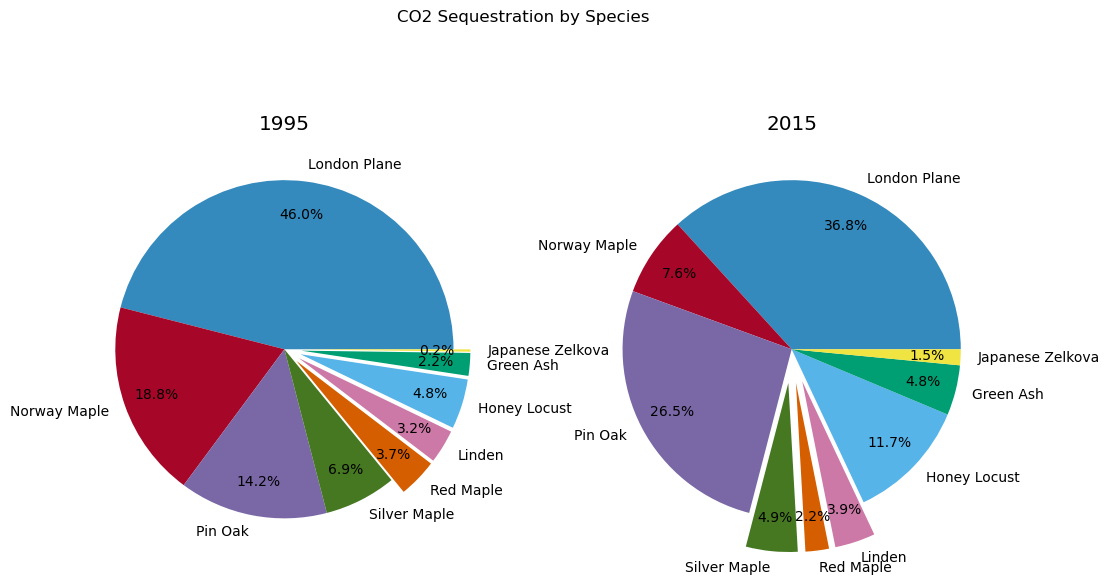

In [123]:
# create pie charts to show relative co2 storage by each species

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,7))
fig.suptitle('CO2 Sequestration by Species')

ax1.pie(co2_storage['1995'],labels=co2_storage.index,autopct='%1.1f%%',
       explode=[0,0,0,0,.1,.1,.1,.1,.1],pctdistance=.8,labeldistance=1.1)
ax1.set_title('1995')

ax2.pie(co2_storage['2015'],labels=co2_storage.index, autopct='%1.1f%%',
       pctdistance=.8,explode=[0,0,0,.2,.2,.2,0,0,0],labeldistance=1.1)
ax2.set_title('2015')

plt.savefig(os.path.join('images','co2_piecharts.png'))
plt.show()
                    

In [126]:
# create barchart to show absolute co2 storage by species

by_year = co2_storage.T                                # transpose dataframe
#by_year.drop('CO2_difference',axis=0,inplace=True)

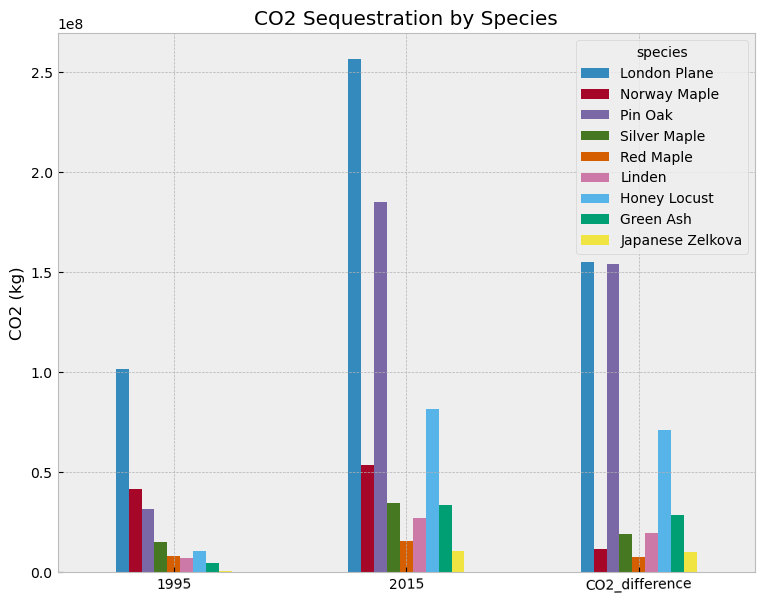

In [127]:
by_year.plot(kind='bar',figsize=(9,7),rot=1,title='CO2 Sequestration by Species',ylabel='CO2 (kg)')

plt.savefig(os.path.join('images','co2_barchart.png'))
plt.show()